In [1]:
import torch
import math

In [2]:
# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda:0") # use GPU
else:
  device= torch.device("cpu")
print(device)

2.7.0+cu126
NVIDIA GeForce RTX 3060 Laptop GPU
cuda:0


## Generating Training Data

In [ ]:
# Step 1: Generate x values (input space)
def generate_x_values(num_points=100, range_min=-10, range_max=10):
    """
    Generates a tensor of x values uniformly spaced in the given range.
    
    Args:
        num_points (int): Number of points to generate.
        range_min (float): Minimum value of the range.
        range_max (float): Maximum value of the range.

    Returns:
        torch.Tensor: Tensor of shape (num_points,)
    """
    return torch.linspace(range_min, range_max, num_points)

# Step 2: Generate component parameters (mean and std) for each component
def generate_component_params(components, num_data):
    """
    Generates parameters for each mixture component for a given batch size.
    
    Args:
        components (list of dicts): Each dict should contain 'mean_range' and 'sigma'.
        num_data (int): Number of samples to generate.

    Returns:
        list of tuples: Each tuple contains (mu, sigma) for a component.
    """
    params = []
    for comp in components:
        mean_range = comp['mean_range']
        sigma = comp['sigma']
        mu = torch.rand(num_data) * (mean_range[1] - mean_range[0]) + mean_range[0]
        params.append((mu, sigma))
    return params

# Step 3: Evaluate the mixture distribution for each sample
def evaluate_mixture(x, component_params):
    """
    Evaluates the mixture distribution for each sample in the batch.
    
    Args:
        x (torch.Tensor): Input values (shape: [num_points]).
        component_params (list of tuples): (mu, sigma) for each component.

    Returns:
        torch.Tensor: Mixture distribution for each sample (shape: [num_data, num_points]).
    """
    num_points = x.shape[0]
    num_data = component_params[0][0].shape[0]
    p = torch.zeros(num_data, num_points)

    for mu, sigma in component_params:
        # Compute Gaussian for this component
        component_p = torch.exp(- (x.unsqueeze(0) - mu.unsqueeze(1)) ** 2 / (2 * sigma ** 2)) / \
                      (sigma * torch.sqrt(torch.tensor(2 * math.pi)))
        p += component_p

    return p

# Step 4: Normalize the mixture distribution to [-1, 1]
def normalize_data(data):
    """
    Normalizes the data to the range [-1, 1] using min-max scaling.

    Args:
        data (torch.Tensor): Tensor of shape [num_data, num_points].

    Returns:
        torch.Tensor: Normalized tensor.
    """
    min_vals, _ = data.min(dim=1, keepdim=True)
    max_vals, _ = data.max(dim=1, keepdim=True)
    data = 2 * (data - min_vals) / (max_vals - min_vals) - 1
    return data


# Step 5: Main function to generate the final output
def generate_mixture_data(components, num_data, num_points=100, range_min=-10, range_max=10):
    """
    Main function to generate mixture data.

    Args:
        components (list of dicts): List of components with 'mean_range' and 'sigma'.
        num_data (int): Number of samples to generate.
        num_points (int): Number of x points.
        range_min (float): Minimum x value.
        range_max (float): Maximum x value.

    Returns:
        torch.Tensor: Normalized mixture data of shape [num_data, num_points].
    """
    x = generate_x_values(num_points, range_min, range_max)
    component_params = generate_component_params(components, num_data)
    mixture_distribution = evaluate_mixture(x, component_params)
    normalized_data = normalize_data(mixture_distribution)
    return normalized_data, x

In [ ]:
import matplotlib.pyplot as plt

def plot_samples(data, x_values, num_samples=2, dpi=100, 
                title="Mixture Distribution Samples", 
                xlabel="X", ylabel="Normalized Value",
                save_path=None):
    """
    Visualize samples from the generated dataset
    
    Args:
        data: Tensor of shape [num_data, num_points]
        x_values: Tensor of shape [num_points] for x-axis
        num_samples: Number of samples to plot
        dpi: Figure resolution
        title: Plot title
        xlabel: X-axis label
        ylabel: Y-axis label
        save_path: If provided, saves figure to this path
    """
    # Ensure we don't request more samples than available
    num_samples = min(num_samples, data.shape[0])
    
    plt.figure(figsize=(12, 4 * num_samples), dpi=dpi)
    
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i+1)
        plt.plot(x_values, data[i], color='blue', linewidth=2)
        plt.grid(True, alpha=0.3)
        plt.title(f"Sample {i+1}", fontsize=10)
        plt.xlabel(xlabel, fontsize=8)
        plt.ylabel(ylabel, fontsize=8)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    else:
        plt.show()
    plt.close()

In [ ]:
# Generate data using your function
components = [
    {'mean_range': (-15, -5), 'sigma': 1.0},
    {'mean_range': (5, 15), 'sigma': 1.0}
]
num_data = 4_000
num_points = 100
range_min, range_max = -20, 20

data, x = generate_mixture_data(components, num_data, num_points, range_min, range_max)
x_values = x

print(data.shape)  # Output: torch.Size([num_data, num_points])

torch.Size([4000, 100])


In [6]:
data

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]])

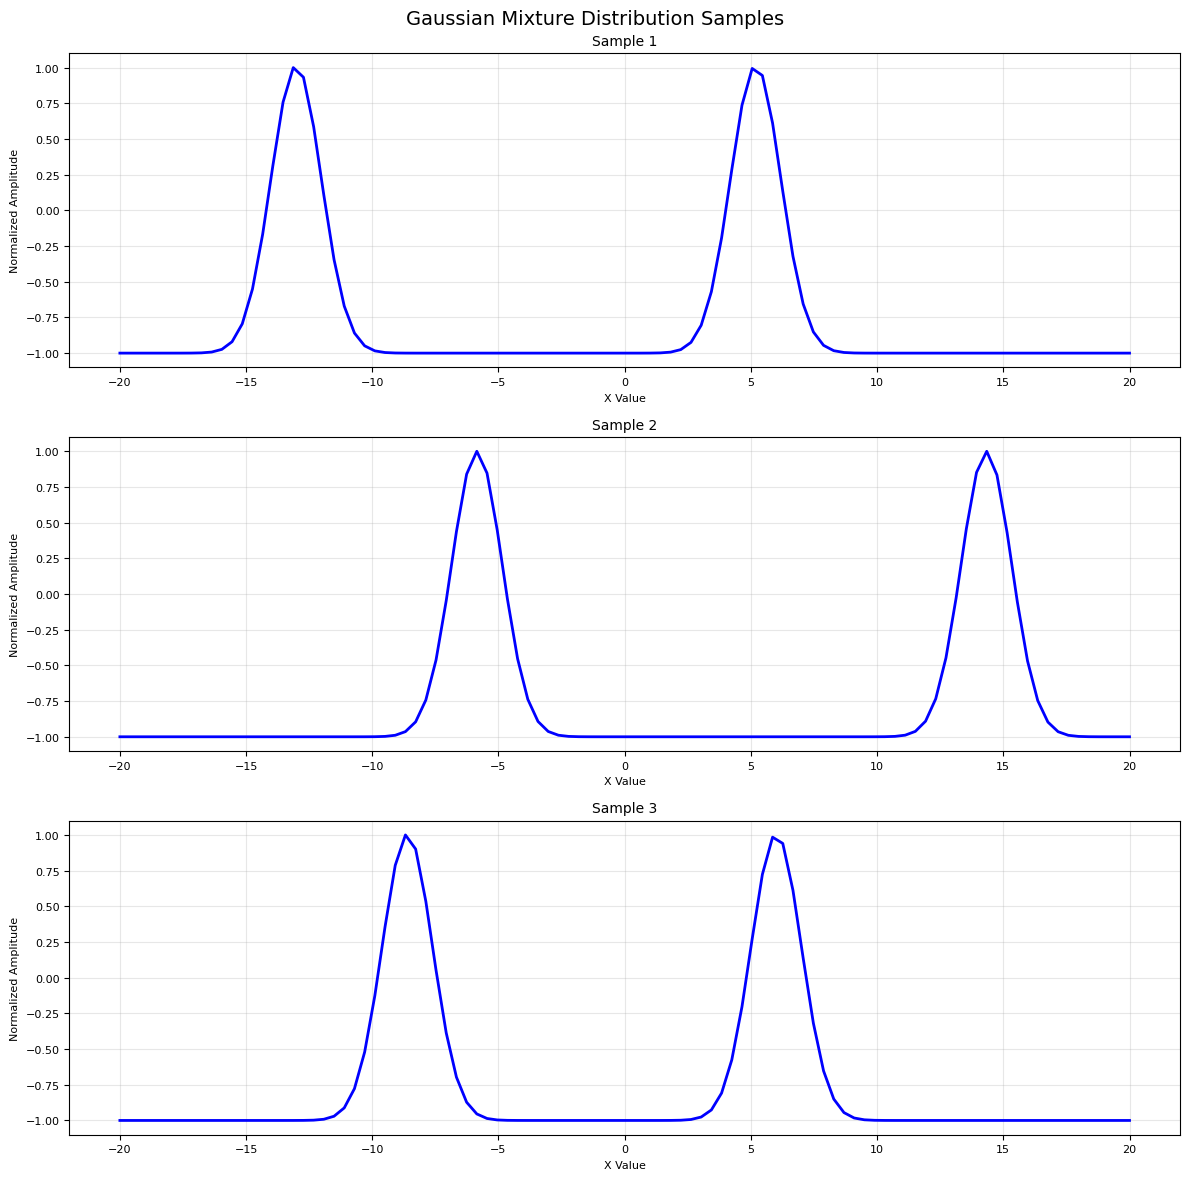

In [7]:
# Visualize samples
plot_samples(
    data=data,
    x_values=x_values,
    num_samples=3,
    title="Gaussian Mixture Distribution Samples",
    xlabel="X Value",
    ylabel="Normalized Amplitude"
)

## Creating Denoising Diffusion Probabilistic model :

### Setting hyperparameters :

In [8]:
# Global constants
N = data.size(0) # number of training data
n = data.size(1) # number of elements in the line 


print(f"Global Constants:\n"
      f"  Number of Training Data (N): {N}\n"
      f"  Number of Elements in the Line (n): {n}")


Global Constants:
  Number of Training Data (N): 4000
  Number of Elements in the Line (n): 100


In [9]:
num_heads = 4 # number of heads in the transformer layer
d = 32 * num_heads # number of hidden dimensions
num_layers = 4 # number of transformer layers
dPEt = d # number of dimensions for the time step of the diffusion model
drop = 0.01 # dropout value
bs = 50 # batch size


print(f"Transformer Parameters:\n"
      f"  Number of Heads: {num_heads}\n"
      f"  Hidden Dimensions (d): {d}\n"
      f"  Number of Layers: {num_layers}\n"
      f"  Dimensions for Time Step (dPEt): {dPEt}\n"
      f"  Dropout Value: {drop}\n"
      f"  Batch Size: {bs}")


Transformer Parameters:
  Number of Heads: 4
  Hidden Dimensions (d): 128
  Number of Layers: 4
  Dimensions for Time Step (dPEt): 128
  Dropout Value: 0.01
  Batch Size: 50


In [10]:
beta_1 = 0.0001 # beta_1 for DM
beta_T = 0.02 # beta_T for DM
num_t = 150 # number of time steps of the DM
alpha_t = 1.0 - torch.linspace(beta_1, beta_T, num_t).to(device) # for DM, size=[num_t] 
alpha_bar_t = torch.cumprod( alpha_t, dim=0) # for DM, size=[num_t] 


print(f"Diffusion Model Parameters:\n"
      f"  Beta 1: {beta_1}\n"
      f"  Beta T: {beta_T}\n"
      f"  Number of Time Steps (num_t): {num_t}")

Diffusion Model Parameters:
  Beta 1: 0.0001
  Beta T: 0.02
  Number of Time Steps (num_t): 150


### Creating Unet model architecture :

In [11]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [12]:
# Define DDPM architecture with Transformers
class head_attention(nn.Module):
    """
    Attention head for the transformer.

    Each head computes attention scores and attends to different parts of the input.
    """
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head) # Linear layer for queries
        self.K = nn.Linear(d, d_head) # Linear layer for keys
        self.V = nn.Linear(d, d_head) # Linear layer for values
        self.sqrt_d = torch.sqrt(torch.tensor(d_head)) # Scaling factor
        self.drop_att = nn.Dropout(drop) # Dropout for attention scores
    def forward(self, x):
        """
        Forward pass for the attention head.

        Args:
            x (torch.Tensor): Input tensor [batch_size, n, d]

        Returns:
            torch.Tensor: Output tensor [batch_size, n, d_head]
        """
        Q = self.Q(x)      # [bs, n, d_head]
        K = self.K(x)      # [bs, n, d_head]
        V = self.V(x)      # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        Att = (Q * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1)        # [bs, n, n]
        Att = self.drop_att(Att) # [bs, n, d_head]
        x = Att @ V              # [bs, n, d_head]
        return x

class MHA(nn.Module):
    """
    Multi-Head Attention module.

    Combines multiple attention heads to capture different aspects of the input.
    """
    def __init__(self, d, num_heads):  
        super().__init__()
        d_head = d // num_heads # Dimension of each head
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] ) # List of attention heads
        self.WOx = nn.Linear(d, d) # Linear layer for output
        self.drop_x = nn.Dropout(drop) # Dropout for output
    def forward(self, x):
        """
        Forward pass for the multi-head attention module.

        Args:
            x (torch.Tensor): Input tensor [batch_size, n, d]

        Returns:
            torch.Tensor: Output tensor [batch_size, n, d]
        """
        x_MHA = []  
        for head in self.heads:
            x_HA = head(x)                    # [bs, n, d_head]
            x_MHA.append(x_HA)
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)                    # [bs, n, d]
        return x

class BlockGT(nn.Module):
    """
    Transformer block.

    Combines multi-head attention and a feedforward network.
    """
    def __init__(self, d, num_heads):  
        super().__init__()
        self.LNx = nn.LayerNorm(d) # Layer normalization
        self.LNx2 = nn.LayerNorm(d) # Layer normalization
        self.MHA = MHA(d, num_heads) # Multi-head attention
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d)) # Feedforward network
        self.drop_x_mlp = nn.Dropout(drop) # Dropout for feedforward network
        self.mu = nn.Linear(d, d, bias=True)
    def forward(self, x):
        """
        Forward pass for the transformer block.

        Args:
            x (torch.Tensor): Input tensor [batch_size, n, d]

        Returns:
            torch.Tensor: Output tensor [batch_size, n, d]
        """
        x_in = x                        # [bs, n, d]
        x = self.LNx(x)                 # [bs, n, d]
        x_MHA = self.MHA(x)             # [bs, n, d]
        x = x_in + x_MHA                # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]
        x = self.drop_x_mlp(x)          # [bs, n, d]
        return x

class UNet(nn.Module):
    """
    UNet architecture for denoising diffusion probabilistic models.

    This class implements a UNet model with transformer layers for denoising data.
    It includes embedding layers for time steps and input data, transformer layers,
    and a final linear layer for output.
    """
    def __init__(self):
        super().__init__()
        self.pe_t_emb = nn.Sequential(nn.Embedding(num_t, dPEt), nn.ReLU(), nn.Linear(dPEt, d))
        self.pe_x = nn.Embedding(n, d)
        self.x_emb = nn.Linear(1, d)
        self.gt_layers = nn.ModuleList( [BlockGT(d, num_heads) for _ in range(num_layers)] )
        self.ln_final = nn.LayerNorm(d)  
        self.linear_final = nn.Linear(d, 1)
        self.drop_x_emb = nn.Dropout(drop)
        self.drop_p_emb = nn.Dropout(drop)
    def forward(self, x_t, sample_t):
        """
        Forward pass of the UNet model.

        Args:
            x_t (torch.Tensor): Input data at timestep t [batch_size, n]
            sample_t (torch.Tensor): Timestep t [batch_size]

        Returns:
            torch.Tensor: Predicted noise at timestep t [batch_size, n]
        """
        x_t = self.x_emb(x_t.unsqueeze(2)) # [bs, n, d]
        bs2 = x_t.size(0)
        pe_x = torch.arange(0,n).to(device).repeat(bs2,1) # [bs, n] 
        pe_x = self.pe_x(pe_x)             # [bs, n, d] 
        x_t = x_t + pe_x                   # [bs, n, d]
        p_t = self.pe_t_emb(sample_t)      # [bs, d]
        x_t = self.drop_x_emb(x_t)         # [bs, n, d]
        p_t = self.drop_p_emb(p_t)         # [bs, d]
        for gt_layer in self.gt_layers:
            x_t = x_t + p_t.unsqueeze(1)   # [bs, n, d]
            x_t = gt_layer(x_t)            # [bs, n, d]
        # output
        x_t = self.ln_final(x_t)           # [bs, n, d]
        x_t_minus_one = self.linear_final(x_t).squeeze()  # [bs, n]
        return x_t_minus_one

In [13]:
class DDPM(nn.Module):
    """
    Denoising Diffusion Probabilistic Model (DDPM) implementation.
    
    This class implements a DDPM that gradually adds noise to data and learns to reverse the process.
    It consists of a forward process (adding noise) and a backward process (denoising) using a UNet
    architecture with transformers.

    Args:
        num_t (int): Number of timesteps in the diffusion process
        beta_1 (float): Initial value of noise schedule (β₁)
        beta_T (float): Final value of noise schedule (βₜ)
    """

    def __init__(self, num_t, beta_1, beta_T):
        super().__init__()
        self.num_t = num_t
        # Define alpha_t and alpha_bar_t
        self.alpha_t = 1.0 - torch.linspace(beta_1, beta_T, num_t).to(device) # [num_t]
        self.alpha_bar_t = torch.cumprod( self.alpha_t, dim=0) # [num_t]

        self.UNet = UNet()

    def forward_process(self, x0, sample_t, noise_x0):
        """
        Forward diffusion process that gradually adds noise to the input data.
        
        Args:
            x0 (torch.Tensor): Initial data points [batch_size, n]
            sample_t (torch.Tensor): Timesteps for each sample [batch_size]
            noise_x0 (torch.Tensor): Noise to be added [batch_size, n]
            
        Returns:
            torch.Tensor: Noisy data points at timestep t [batch_size, n]
        """
        bs2 = len(sample_t)
        sqrt_alpha_bar_t = self.alpha_bar_t[sample_t].sqrt()                     # [bs]
        sqrt_one_minus_alpha_bar_t = ( 1.0 - self.alpha_bar_t[sample_t] ).sqrt() # [bs]
        x_t = sqrt_alpha_bar_t.view(bs2,1) * x0 + sqrt_one_minus_alpha_bar_t.view(bs2,1) * noise_x0 # [bs, n]
        return x_t

    def backward_process(self, x_t, sample_t):
        """
        Backward diffusion process that predicts the noise at timestep t.
        
        Args:
            x_t (torch.Tensor): Noisy data points at timestep t [batch_size, n]
            sample_t (torch.Tensor): Current timesteps [batch_size]
            
        Returns:
            torch.Tensor: Predicted noise at timestep t [batch_size, n]
        """
        noise_pred_x_t = self.UNet(x_t, sample_t) # [bs, n]
        return noise_pred_x_t

    def generate_process_ddpm(self, num_mol):
        """
        Generate new samples using the DDPM model by running the reverse diffusion process.
        
        The process starts from pure noise and gradually denoises it using the learned model
        to generate samples that match the training data distribution.
        
        Args:
            num_mol (int): Number of samples to generate
            
        Returns:
            torch.Tensor: Generated samples [num_mol, n]
        """
        t = num_t - 1
        bs = num_mol
        batch_t = (t * torch.ones(bs)).long().to(device)
        batch_x_t = torch.randn(bs, n).to(device) # t=T => t=T-1 in python
        set_t = list(range(t-1,0,-1)); set_t = set_t + [0]
        
        for t_minus_one in set_t: # for t=T,T-step_size,T-2*step_size,...,step_size,0
            batch_t_minus_one = (t_minus_one * torch.ones(bs)).long().to(device)
            # x_t, t -> x_t-1
            batch_noise_pred_x_t = self.backward_process(batch_x_t, batch_t)
            
            # Calculate diffusion parameters
            sigma_t = ( (1.0-self.alpha_bar_t[t_minus_one])/ (1.0-self.alpha_bar_t[t])* 
                       (1.0-self.alpha_bar_t[t]/self.alpha_bar_t[t_minus_one]) ).sqrt()
            c1 = self.alpha_bar_t[t_minus_one].sqrt() / self.alpha_bar_t[t].sqrt()
            c2 = ( 1.0 - self.alpha_bar_t[t] + 1e-10 ).sqrt()
            c3 = ( 1.0 - self.alpha_bar_t[t_minus_one] - sigma_t.square() + 1e-10 ).sqrt()
            
            # Update sample for next iteration
            batch_x_t_minus_one = c1 * ( batch_x_t - c2 * batch_noise_pred_x_t ) + \
                c3 * batch_noise_pred_x_t + sigma_t* torch.randn(bs, n).to(device)
            
            t = t_minus_one
            batch_x_t = batch_x_t_minus_one
            batch_t = batch_t_minus_one
            
        return batch_x_t

In [14]:
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6


In [15]:
net = DDPM(num_t, beta_1, beta_T)
net = net.to(device)
_ = display_num_param(net)

Number of parameters: 908289 (0.91 million)


In [16]:
# Optimizer
init_lr = 0.0003
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1)

epoch= 0 	 time= 0.0805 min 	 lr= 0.0003 	 loss= 0.4646
epoch= 1 	 time= 0.1450 min 	 lr= 0.0003 	 loss= 0.2736
epoch= 2 	 time= 0.2097 min 	 lr= 0.0003 	 loss= 0.2461
epoch= 3 	 time= 0.2740 min 	 lr= 0.0003 	 loss= 0.2426
epoch= 4 	 time= 0.3385 min 	 lr= 0.0003 	 loss= 0.2343
epoch= 5 	 time= 0.4028 min 	 lr= 0.0003 	 loss= 0.2247
epoch= 6 	 time= 0.4680 min 	 lr= 0.0003 	 loss= 0.2039
epoch= 7 	 time= 0.5324 min 	 lr= 0.0003 	 loss= 0.1767
epoch= 8 	 time= 0.5967 min 	 lr= 0.0003 	 loss= 0.1530
epoch= 9 	 time= 0.6624 min 	 lr= 0.0003 	 loss= 0.1371
epoch= 10 	 time= 0.7275 min 	 lr= 0.0003 	 loss= 0.1240


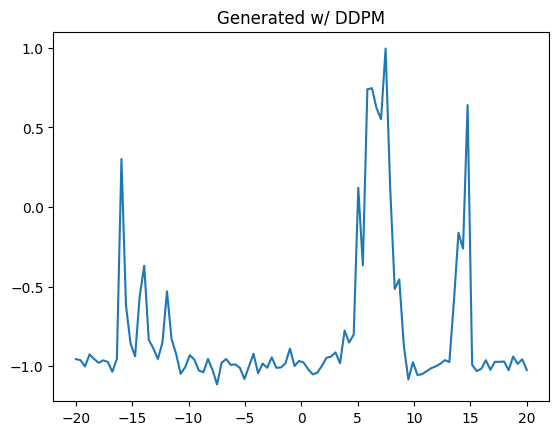

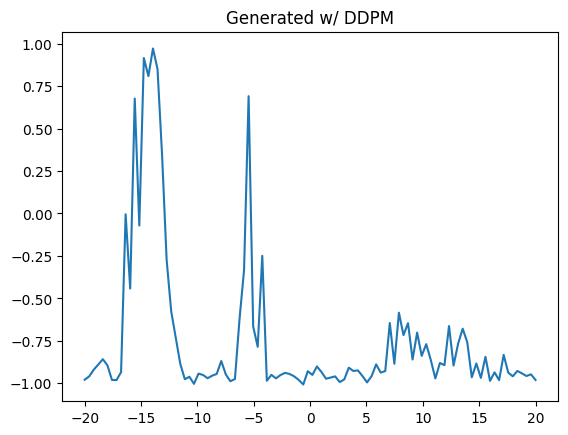

epoch= 11 	 time= 0.8287 min 	 lr= 0.0003 	 loss= 0.1165
epoch= 12 	 time= 0.8955 min 	 lr= 0.0003 	 loss= 0.1160
epoch= 13 	 time= 0.9616 min 	 lr= 0.0003 	 loss= 0.1087
epoch= 14 	 time= 1.0269 min 	 lr= 0.0003 	 loss= 0.1053
epoch= 15 	 time= 1.0929 min 	 lr= 0.0003 	 loss= 0.1081
epoch= 16 	 time= 1.1591 min 	 lr= 0.0003 	 loss= 0.1023
epoch= 17 	 time= 1.2264 min 	 lr= 0.0003 	 loss= 0.1033
epoch= 18 	 time= 1.2924 min 	 lr= 0.0003 	 loss= 0.0979
epoch= 19 	 time= 1.3596 min 	 lr= 0.0003 	 loss= 0.0970
epoch= 20 	 time= 1.4257 min 	 lr= 0.0003 	 loss= 0.0989


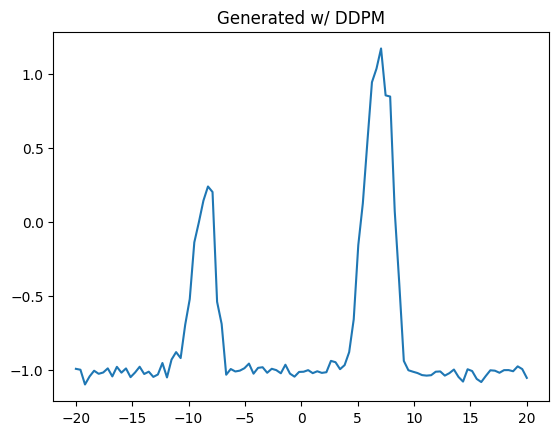

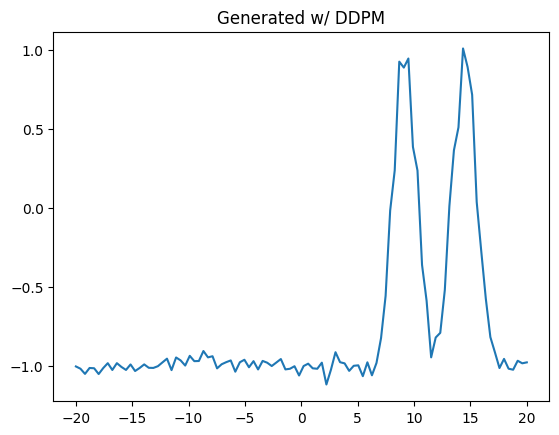

epoch= 21 	 time= 1.5458 min 	 lr= 0.0003 	 loss= 0.0955
epoch= 22 	 time= 1.6133 min 	 lr= 0.0003 	 loss= 0.0932
epoch= 23 	 time= 1.6797 min 	 lr= 0.0003 	 loss= 0.0909
epoch= 24 	 time= 1.7488 min 	 lr= 0.0003 	 loss= 0.0927
epoch= 25 	 time= 1.8160 min 	 lr= 0.0003 	 loss= 0.0900
epoch= 26 	 time= 1.8838 min 	 lr= 0.0003 	 loss= 0.0894
epoch= 27 	 time= 1.9515 min 	 lr= 0.0003 	 loss= 0.0907
epoch= 28 	 time= 2.0199 min 	 lr= 0.0003 	 loss= 0.0878
epoch= 29 	 time= 2.0873 min 	 lr= 0.0003 	 loss= 0.0896
epoch= 30 	 time= 2.1530 min 	 lr= 0.0003 	 loss= 0.0842


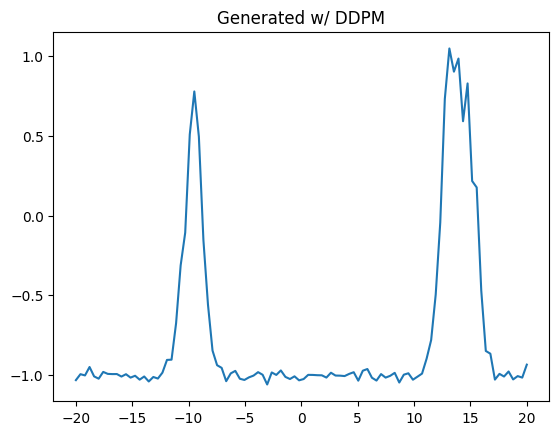

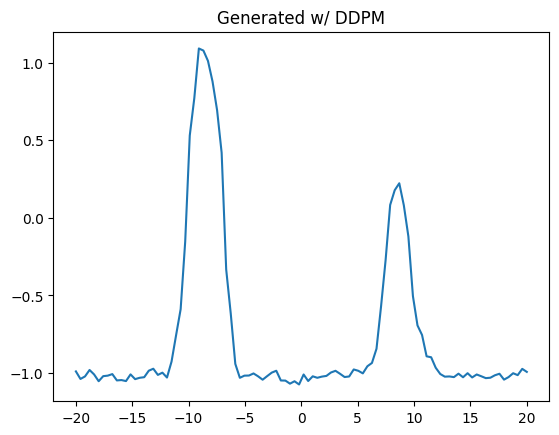

epoch= 31 	 time= 2.2426 min 	 lr= 0.0003 	 loss= 0.0837
epoch= 32 	 time= 2.3115 min 	 lr= 0.0003 	 loss= 0.0832
epoch= 33 	 time= 2.3794 min 	 lr= 0.0003 	 loss= 0.0826
epoch= 34 	 time= 2.4484 min 	 lr= 0.0003 	 loss= 0.0831
epoch= 35 	 time= 2.5169 min 	 lr= 0.000285 	 loss= 0.0828
epoch= 36 	 time= 2.5846 min 	 lr= 0.000285 	 loss= 0.0801
epoch= 37 	 time= 2.6527 min 	 lr= 0.000285 	 loss= 0.0811
epoch= 38 	 time= 2.7201 min 	 lr= 0.00027075 	 loss= 0.0814
epoch= 39 	 time= 2.7886 min 	 lr= 0.00027075 	 loss= 0.0798
epoch= 40 	 time= 2.8567 min 	 lr= 0.00027075 	 loss= 0.0797


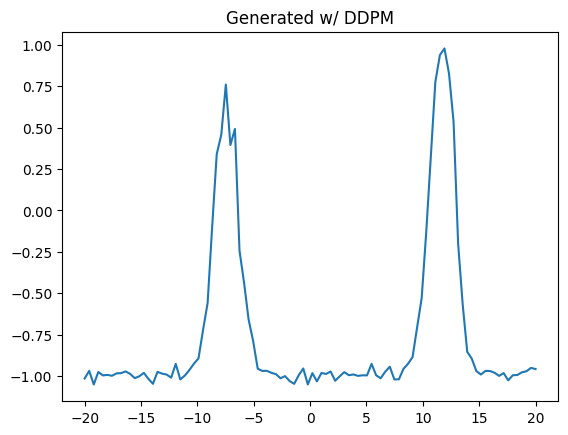

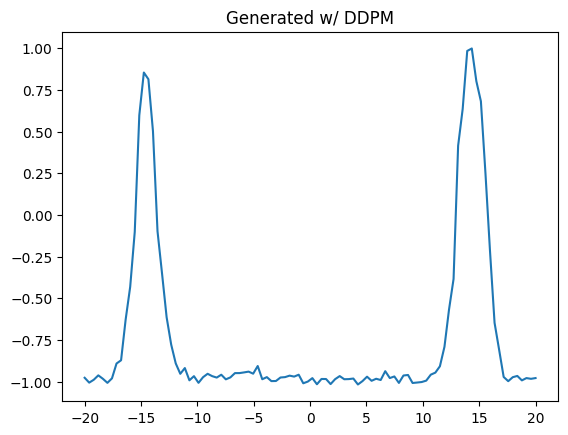

epoch= 41 	 time= 2.9503 min 	 lr= 0.00027075 	 loss= 0.0791
epoch= 42 	 time= 3.0200 min 	 lr= 0.00027075 	 loss= 0.0796
epoch= 43 	 time= 3.0897 min 	 lr= 0.00027075 	 loss= 0.0767
epoch= 44 	 time= 3.1595 min 	 lr= 0.00027075 	 loss= 0.0760
epoch= 45 	 time= 3.2280 min 	 lr= 0.00027075 	 loss= 0.0721
epoch= 46 	 time= 3.2982 min 	 lr= 0.00027075 	 loss= 0.0783
epoch= 47 	 time= 3.3708 min 	 lr= 0.0002572125 	 loss= 0.0755
epoch= 48 	 time= 3.4502 min 	 lr= 0.0002572125 	 loss= 0.0762
epoch= 49 	 time= 3.5394 min 	 lr= 0.000244351875 	 loss= 0.0744


In [17]:
# Number of mini-batches per epoch
nb_epochs = 50
start = time.time()
for epoch in range(nb_epochs):

    running_loss = 0.0
    num_batches = 0

    shuffled_indices = torch.randperm(N)
    for count in range(0,N,bs):

        idx_data = shuffled_indices[count : count+bs]
        batch_x0 = data[idx_data,:].to(device) # [bs, n]
        batch_sample_t = torch.randint(0, num_t, (batch_x0.size(0),)).long().to(device) # random interger in {0,1,...,T-1} [bs]
        bs2, n = batch_x0.size()
        batch_noise_x_t = torch.randn(bs2,n).to(device) # [bs, n]
        x_t = net.forward_process(batch_x0, batch_sample_t, batch_noise_x_t) # [bs, n]
        noise_pred_x_t = net.backward_process(x_t, batch_sample_t) # [bs, n]
        loss_DDPM = torch.nn.MSELoss()(noise_pred_x_t, batch_noise_x_t) 
        loss = loss_DDPM
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25)
        optimizer.step()
        
        # Compute stats
        running_loss += loss.detach().item()
        num_batches += 1

    # Average stats
    mean_loss = running_loss/num_batches
    scheduler.step(mean_loss)
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', str(elapsed)[:6],'min', '\t lr=', optimizer.param_groups[0]['lr']  ,'\t loss=', str(mean_loss)[:6] )

    # Plot intermediate generated data
    if not epoch%10 and epoch>0:
        x_fake = net.generate_process_ddpm(2)
        plt.plot(x, x_fake[0].detach().cpu()); plt.title("Generated w/ DDPM"); plt.show()
        plt.plot(x, x_fake[1].detach().cpu()); plt.title("Generated w/ DDPM"); plt.show()

    # Check lr value
    if optimizer.param_groups[0]['lr'] < 10**-4: 
      print("\n lr is equal to min lr -- training stopped\n")
      break